In [1]:
import triton
print(triton.__version__)

3.2.0


In [2]:
import torch
print(torch.__version__)

2.6.0+cu124


Testing matmul: M=64, N=64, K=128, dtype_a=torch.float8_e5m2, dtype_b=torch.float8_e5m2
  Forward pass: 100.00% of values are within 0.01 of PyTorch output.
  Backward pass (grad_a): 100.00% of values are within 0.01 of PyTorch output.
  Backward pass (grad_b): 100.00% of values are within 0.01 of PyTorch output.
All matmul tests passed!


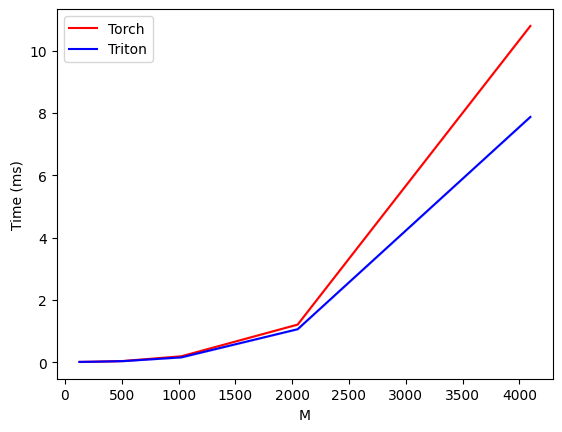

Matmul Benchmark:
        M       N       K      Torch    Triton
0   128.0   128.0   128.0   0.012990  0.013919
1   256.0   256.0   256.0   0.021539  0.019369
2   512.0   512.0   512.0   0.042821  0.039223
3  1024.0  1024.0  1024.0   0.194206  0.158553
4  2048.0  2048.0  2048.0   1.210880  1.062267
5  4096.0  4096.0  4096.0  10.790570  7.871694


In [3]:
import torch
import triton
import triton.language as tl
import math
import triton.testing

DEVICE = "cuda"

@triton.jit
def matmul_kernel(
        a_ptr, b_ptr, c_ptr,
        M, N, K,
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr = 32, BLOCK_SIZE_N: tl.constexpr = 32, BLOCK_SIZE_K: tl.constexpr = 32, GROUP_SIZE_M: tl.constexpr = 16,
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = tl.minimum(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    
    c_output = accumulator.to(c_ptr.dtype.element_ty)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_store_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_store_ptrs, c_output, mask=c_mask)

def _matmul_launcher(a, b):
    # a: [M, K] and b: [K, N] -> returns [M, N]
    M, K = a.shape
    _, N = b.shape
    # allocate output in BF16 after FP32 accumulation
    c = torch.empty((M, N), device=a.device, dtype=torch.bfloat16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) *
                         triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c

class _Matmul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b):
        # Retain gradients for non-leaf input tensors if they require grad
        if a.requires_grad:
            a.retain_grad()
        if b.requires_grad:
            b.retain_grad()
        # Convert inputs to fp8 for computation
        a_fp8 = a.to(torch.float8_e5m2)
        b_fp8 = b.to(torch.float8_e5m2)
        
        if not a_fp8.is_contiguous() or not b_fp8.is_contiguous():
            a_fp8 = a_fp8.contiguous()
            b_fp8 = b_fp8.contiguous()
            
        assert a_fp8.shape[1] == b_fp8.shape[0], "Incompatible dimensions for matmul"
        c = _matmul_launcher(a_fp8, b_fp8)
        ctx.save_for_backward(a, b)
        return c

    @staticmethod
    def backward(ctx, grad_c):
        a, b = ctx.saved_tensors
        with torch.no_grad():
            # Use BF16 for backward matmuls to improve precision
            grad_c_bf16 = grad_c.to(torch.bfloat16)
            grad_a = _matmul_launcher(
                grad_c_bf16,
                b.to(torch.bfloat16).transpose(-2, -1).contiguous()
            )
            grad_b = _matmul_launcher(
                a.to(torch.bfloat16).transpose(-2, -1).contiguous(),
                grad_c_bf16
            )
        return grad_a, grad_b

matmul = _Matmul.apply

# Benchmark against torch.matmul
configs = [
    triton.testing.Benchmark(
        x_names=["M","N","K"],
        x_vals=[128,256,512,1024,2048,4096],
        line_arg="provider",
        line_vals=["Torch","Triton"],
        line_names=["Torch","Triton"],
        styles=[("red","-"),("blue","-")],
        ylabel="Time (ms)",
        plot_name="Matmul Benchmark",
        args={"dtype": torch.float32},
    )
]

@triton.testing.perf_report(configs)
def benchmark_matmul(M, N, K, provider, dtype):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    a = torch.randn((M, K), device=device, dtype=dtype)
    b = torch.randn((K, N), device=device, dtype=dtype)
    if provider == "Torch":
        result = triton.testing.do_bench(lambda: torch.matmul(a, b))
    else:
        result = triton.testing.do_bench(lambda: matmul(a, b))
    if isinstance(result, tuple):
        ms, min_ms, max_ms = result
    else:
        ms = min_ms = max_ms = result
    return ms, min_ms, max_ms

if __name__ == "__main__":
    test_configs = [
        {"M": 64, "N": 64, "K": 128, "dtype_a": torch.float8_e5m2, "dtype_b": torch.float8_e5m2},
    ]
    for config in test_configs:
        M, N, K = config["M"], config["N"], config["K"]
        dtype_a, dtype_b = config["dtype_a"], config["dtype_b"]
        print(f"Testing matmul: M={M}, N={N}, K={K}, dtype_a={dtype_a}, dtype_b={dtype_b}")
        a = torch.randn((M, K), device=DEVICE, dtype=torch.bfloat16, requires_grad=True).to(dtype_a)
        b = torch.randn((K, N), device=DEVICE, dtype=torch.bfloat16, requires_grad=True).to(dtype_b)
        a_ref = a.clone().detach().requires_grad_(True)
        b_ref = b.clone().detach().requires_grad_(True)
        c_triton = matmul(a.contiguous(), b.contiguous())
        c_torch = torch.matmul(a_ref.to(torch.bfloat16), b_ref.to(torch.bfloat16))
        correct_elements_fwd = torch.isclose(c_triton, c_torch, atol=0.01, rtol=0.01).sum().item()
        total_elements_fwd = c_torch.numel()
        percentage_correct_fwd = (correct_elements_fwd / total_elements_fwd) * 100
        print(f"  Forward pass: {percentage_correct_fwd:.2f}% of values are within 0.01 of PyTorch output.")
        assert percentage_correct_fwd >= 89.0, f"Forward pass accuracy too low: {percentage_correct_fwd:.2f}% (Triton: {c_triton.dtype}, Torch: {c_torch.dtype})"
        grad_c = torch.randn_like(c_triton)
        grad_c_clone_for_triton = grad_c.clone()
        grad_c_clone_for_torch = grad_c.clone()
        c_triton.backward(grad_c_clone_for_triton)
        c_torch.backward(grad_c_clone_for_torch)
        if a.grad is not None and a_ref.grad is not None:
            correct_elements_bwd_a = torch.isclose(a.grad.float(), a_ref.grad.float(), atol=0.01, rtol=0.01).sum().item()
            total_elements_bwd_a = a_ref.grad.numel()
            percentage_correct_bwd_a = (correct_elements_bwd_a / total_elements_bwd_a) * 100
            print(f"  Backward pass (grad_a): {percentage_correct_bwd_a:.2f}% of values are within 0.01 of PyTorch output.")
            assert percentage_correct_bwd_a >= 99.0, f"Backward pass accuracy for grad_a too low: {percentage_correct_bwd_a:.2f}%"
        elif not (a.grad is None and (a_ref.grad is None or a_ref.grad.float().abs().sum() == 0)) and not (a_ref.grad is None and (a.grad is None or a.grad.float().abs().sum() == 0)):
            assert False, f"Grad_a mismatch: Triton grad {a.grad}, Torch grad {a_ref.grad}"
        if b.grad is not None and b_ref.grad is not None:
            correct_elements_bwd_b = torch.isclose(b.grad.float(), b_ref.grad.float(), atol=0.01, rtol=0.01).sum().item()
            total_elements_bwd_b = b_ref.grad.numel()
            percentage_correct_bwd_b = (correct_elements_bwd_b / total_elements_bwd_b) * 100
            print(f"  Backward pass (grad_b): {percentage_correct_bwd_b:.2f}% of values are within 0.01 of PyTorch output.")
            assert percentage_correct_bwd_b >= 99.0, f"Backward pass accuracy for grad_b too low: {percentage_correct_bwd_b:.2f}%"
        elif not (b.grad is None and (b_ref.grad is None or b_ref.grad.float().abs().sum() == 0)) and not (b_ref.grad is None and (b.grad is None or b.grad.float().abs().sum() == 0)):
            assert False, f"Grad_b mismatch: Triton grad {b.grad}, Torch grad {b_ref.grad}"
    print("All matmul tests passed!")
    benchmark_matmul.run(show_plots=True, print_data=True)
